## Percobaan 2 - Model Prediksi Titik Panas di Sumatera Selatan 2001 - 2023

- Jika dipengaruhi oleh enso

In [1]:
# pustaka manipulasi data array
import numpy as np

# pustaka manipulasi data frame
import pandas as pd
from pandas import concat
from pandas import DataFrame
from pandas import read_csv
from pandas import read_excel

import random as rm
import time as tm

# pustaka untuk visualisasi data
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter

# library normalize data with max-min algorithm
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# library algorithm lstm-rnn with keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import RNN
from keras.layers import LSTM
from keras.layers import GRU
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import TimeDistributed
from keras.layers import Bidirectional
from keras.optimizers import Adam, Adamax, RMSprop, SGD
from keras.layers import LeakyReLU

# pustaka untuk visualisasi acf dan pacf
import scipy.stats as sc
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf

# pustaka untuk  evaluasi model prediksi
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

### Config Models

In [2]:
# Setting seed
rm.seed(1234)
np.random.seed(1234)
tf.random.set_seed(1234)

In [3]:
# Setting Algorithm
algorithm = "LSTM-RNN"

In [4]:
# # Setting Algorithm
# algorithm = "GRU-RNN"

### 1. Akuisisi Data

In [5]:
# Set waktu komputasi
start = tm.time()

In [6]:
dataset = pd.read_csv("dataset/dataset_enso.csv", parse_dates=["acq_date"])

In [7]:
# menampilkan metadata dataset
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 276 entries, 0 to 275
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   acq_date  276 non-null    datetime64[ns]
 1   hotspot   276 non-null    int64         
 2   sst_std   276 non-null    float64       
 3   sst_anom  276 non-null    float64       
 4   oni_std   276 non-null    float64       
 5   oni_anom  276 non-null    float64       
 6   soi_std   276 non-null    float64       
 7   soi_anom  276 non-null    float64       
dtypes: datetime64[ns](1), float64(6), int64(1)
memory usage: 17.4 KB


In [8]:
print(dataset.head())

    acq_date  hotspot  sst_std  sst_anom  oni_std  oni_anom  soi_std  soi_anom
0 2001-01-31        3    25.81     -0.76    25.88     -0.68      1.0       1.6
1 2001-02-28        5    26.18     -0.56    26.26     -0.52      1.7       2.8
2 2001-03-31       10    26.86     -0.37    26.76     -0.44      0.9       1.5
3 2001-04-30       20    27.24     -0.56    27.25     -0.34      0.2       0.3
4 2001-05-31       39    27.42     -0.46    27.49     -0.25     -0.5      -0.8


### 2. Praproses Data

- Seleksi Fitur

In [9]:
# # jika hotspot dipengaruhi oleh enso
# data = dataset[["hotspot", "sst_std", "sst_anom", "oni_std", "oni_anom", "soi_std", "soi_anom"]]
# data = data.values

# jika hotspot dipengaruhi oleh enso
data = dataset[["hotspot", "sst_anom", "oni_anom", "soi_anom"]]
data = data.values

In [10]:
# hasil seleksi fitur
np.round(data[:5],7)

array([[ 3.  , -0.76, -0.68,  1.6 ],
       [ 5.  , -0.56, -0.52,  2.8 ],
       [10.  , -0.37, -0.44,  1.5 ],
       [20.  , -0.56, -0.34,  0.3 ],
       [39.  , -0.46, -0.25, -0.8 ]])

In [11]:
# cek dimensi normalisasi
data.shape

(276, 4)

- Normalisasi Data

In [12]:
# normalize features
scaler = MinMaxScaler(feature_range=(-1, 1))
scaled = scaler.fit_transform(np.array(data))

In [13]:
# show data train
np.round(scaled[:5],4)

array([[-1.    , -0.6148, -0.5514,  0.36  ],
       [-0.9997, -0.522 , -0.4766,  0.6   ],
       [-0.999 , -0.4339, -0.4393,  0.34  ],
       [-0.9976, -0.522 , -0.3925,  0.1   ],
       [-0.995 , -0.4756, -0.3505, -0.12  ]])

In [14]:
# cek dimensi normalisasi
scaled.shape

(276, 4)

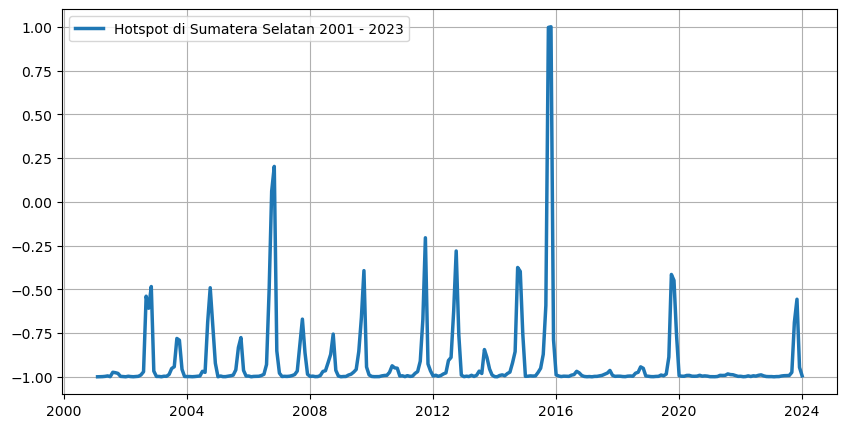

In [15]:
# membuat frame
fig, ax = plt.subplots(figsize = (10,5))

# membuat time series plot
ax.plot(dataset["acq_date"], np.array(scaled[:,:1]), color="tab:blue", label="Hotspot di Sumatera Selatan 2001 - 2023", linewidth=2.5)

# membuat label-label
ax.set_title("", fontsize=14)
ax.set_xlabel("", fontsize=12)
ax.set_ylabel("", fontsize=12)
ax.legend(loc="upper left")
ax.grid(True)

# menampilkan plot
plt.show()

### 3. Pembagian Data

In [16]:
# data train
train_size = 216

# set loc data train
train_data = scaled[0:train_size,:]

# show data train
np.round(train_data[:5],4)

array([[-1.    , -0.6148, -0.5514,  0.36  ],
       [-0.9997, -0.522 , -0.4766,  0.6   ],
       [-0.999 , -0.4339, -0.4393,  0.34  ],
       [-0.9976, -0.522 , -0.3925,  0.1   ],
       [-0.995 , -0.4756, -0.3505, -0.12  ]])

In [17]:
train_data.shape

(216, 4)

In [18]:
# data test
test_size = 60

# set loc data test
test_data = scaled[train_size:len(scaled),:]

# show data test
np.round(test_data[:5],4)

array([[-0.999 ,  0.0487,  0.1168,  0.02  ],
       [-0.9993,  0.0673,  0.1028, -0.42  ],
       [-0.9979,  0.1879,  0.0981, -0.06  ],
       [-0.9975,  0.0719,  0.0748,  0.08  ],
       [-0.99  ,  0.0858,  0.0187, -0.1   ]])

In [19]:
test_data.shape

(60, 4)

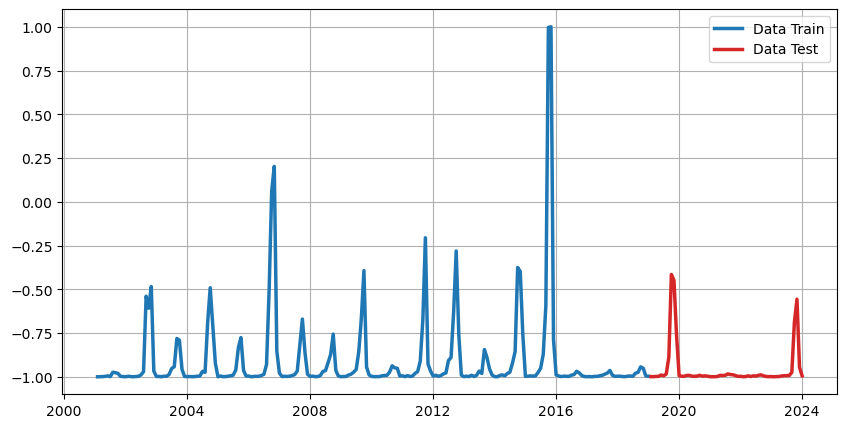

In [20]:
# make a frame
fig, ax = plt.subplots(figsize = (10,5))

# make a time series plot
ax.plot(dataset.iloc[0:len(train_data),0], train_data[:,:1], color="tab:blue", label="Data Train", linewidth=2.5)
ax.plot(dataset.iloc[len(train_data):len(dataset),0], test_data[:,:1], color="tab:red", label="Data Test", linewidth=2.5)

# make are labels
ax.set_title("", fontsize=14)
ax.set_xlabel("", fontsize=12)
ax.set_ylabel("", fontsize=12)
ax.legend(loc="best")
ax.grid(True)

# show plot time series
plt.show()

### 4. Supervised Learning

In [21]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    
    # return value
    return agg

- hasil supervised learning data train

In [22]:
# set supervised learning for data train
reframed_train = series_to_supervised(train_data, 1, 1)

In [23]:
reframed_train.head()

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var1(t),var2(t),var3(t),var4(t)
1,-1.000000,-0.614849,-0.551402,0.36,-0.999723,-0.522042,-0.476636,0.60
2,-0.999723,-0.522042,-0.476636,0.60,-0.999030,-0.433875,-0.439252,0.34
3,-0.999030,-0.433875,-0.439252,0.34,-0.997644,-0.522042,-0.392523,0.10
4,-0.997644,-0.522042,-0.392523,0.10,-0.995012,-0.475638,-0.350467,-0.12
5,-0.995012,-0.475638,-0.350467,-0.12,-0.999307,-0.336427,-0.289720,0.14


In [24]:
# drop columns we don't want to predict
reframed_train.drop(reframed_train.columns[[5,6,7]], axis=1, inplace=True)

In [25]:
reframed_train.head(5)

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var1(t)
1,-1.000000,-0.614849,-0.551402,0.36,-0.999723
2,-0.999723,-0.522042,-0.476636,0.60,-0.999030
3,-0.999030,-0.433875,-0.439252,0.34,-0.997644
4,-0.997644,-0.522042,-0.392523,0.10,-0.995012
5,-0.995012,-0.475638,-0.350467,-0.12,-0.999307


In [26]:
# split into input and outputs
trainX, trainY = reframed_train.iloc[:, :-1], reframed_train.iloc[:, -1]

In [27]:
# view a dimension dataset after supervised learning
print(trainX.shape, trainY.shape)

(215, 4) (215,)


- hasil supervised learning data test

In [28]:
# set supervised learning for data test
reframed_test = series_to_supervised(test_data, 1, 1)

In [29]:
reframed_test.head(5)

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var1(t),var2(t),var3(t),var4(t)
1,-0.999030,0.048724,0.116822,0.02,-0.999307,0.067285,0.102804,-0.42
2,-0.999307,0.067285,0.102804,-0.42,-0.997922,0.187935,0.098131,-0.06
3,-0.997922,0.187935,0.098131,-0.06,-0.997506,0.071926,0.074766,0.08
4,-0.997506,0.071926,0.074766,0.08,-0.990024,0.085847,0.018692,-0.10
5,-0.990024,0.085847,0.018692,-0.10,-0.994319,0.016241,-0.023364,-0.10


In [30]:
# drop columns we don't want to predict
reframed_test.drop(reframed_test.columns[[5,6,7]], axis=1, inplace=True)

In [31]:
reframed_test.head(5)

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var1(t)
1,-0.999030,0.048724,0.116822,0.02,-0.999307
2,-0.999307,0.067285,0.102804,-0.42,-0.997922
3,-0.997922,0.187935,0.098131,-0.06,-0.997506
4,-0.997506,0.071926,0.074766,0.08,-0.990024
5,-0.990024,0.085847,0.018692,-0.10,-0.994319


In [32]:
# split into input and outputs
testX, testY = reframed_test.iloc[:, :-1], reframed_test.iloc[:, -1]

In [33]:
# view a dimension dataset after supervised learning
print(testX.shape, testY.shape)

(59, 4) (59,)


- Check data train, for result supervised learning

In [34]:
temp_trainX = pd.DataFrame(trainX)
temp_trainY = pd.DataFrame(trainY)

In [35]:
hasil_train = pd.concat([temp_trainX, temp_trainY], axis=1)
hasil_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 215 entries, 1 to 215
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   var1(t-1)  215 non-null    float64
 1   var2(t-1)  215 non-null    float64
 2   var3(t-1)  215 non-null    float64
 3   var4(t-1)  215 non-null    float64
 4   var1(t)    215 non-null    float64
dtypes: float64(5)
memory usage: 10.1 KB


In [36]:
hasil_train.head()

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var1(t)
1,-1.000000,-0.614849,-0.551402,0.36,-0.999723
2,-0.999723,-0.522042,-0.476636,0.60,-0.999030
3,-0.999030,-0.433875,-0.439252,0.34,-0.997644
4,-0.997644,-0.522042,-0.392523,0.10,-0.995012
5,-0.995012,-0.475638,-0.350467,-0.12,-0.999307


- Check data test, for result supervised learning

In [37]:
temp_testX = pd.DataFrame(testX)
temp_testY = pd.DataFrame(testY)

In [38]:
hasil_test = pd.concat([temp_testX, temp_testY], axis=1)
hasil_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 59 entries, 1 to 59
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   var1(t-1)  59 non-null     float64
 1   var2(t-1)  59 non-null     float64
 2   var3(t-1)  59 non-null     float64
 3   var4(t-1)  59 non-null     float64
 4   var1(t)    59 non-null     float64
dtypes: float64(5)
memory usage: 2.8 KB


In [39]:
hasil_test.head()

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var1(t)
1,-0.999030,0.048724,0.116822,0.02,-0.999307
2,-0.999307,0.067285,0.102804,-0.42,-0.997922
3,-0.997922,0.187935,0.098131,-0.06,-0.997506
4,-0.997506,0.071926,0.074766,0.08,-0.990024
5,-0.990024,0.085847,0.018692,-0.10,-0.994319


- reshape input for samples, time steps, features

In [40]:
# reshape data train
trainX = np.reshape(np.array(trainX), (trainX.shape[0], 1, trainX.shape[1]))

In [41]:
print(trainX.shape, trainY.shape)

(215, 1, 4) (215,)


In [42]:
# reshape data test
testX = np.reshape(np.array(testX), (testX.shape[0], 1, testX.shape[1]))

In [43]:
print(testX.shape, testY.shape)

(59, 1, 4) (59,)


### 5. Model Prediksi Titik Panas

In [44]:
# call function
from class_base_model import lstm_algorithm
from class_base_model import gru_algorithm

# set parameter
activation = "elu"
dropout_rate = 0.20
optimizer = "rmsprop"
batch_size = 20
epochs=2000

# check algorithm
if algorithm == "algorithm":
    # call model LSTM-RNN
    model = lstm_algorithm(trainX, activation, dropout_rate, optimizer)
else:
    # call model GRU-RNN
    model = gru_algorithm(trainX, activation, dropout_rate, optimizer)

# fit network
history = model.fit(
    trainX, trainY, batch_size=batch_size, epochs=epochs,
    validation_data=(testX, testY), verbose=1, shuffle=False, use_multiprocessing=True
)

Epoch 1/2000
11/11 [==============================] - 12s 125ms/step - loss: 0.8735 - mean_absolute_error: 0.8735 - mean_squared_error: 0.7931 - mean_absolute_percentage_error: 94.1726 - val_loss: 0.7630 - val_mean_absolute_error: 0.7630 - val_mean_squared_error: 0.5965 - val_mean_absolute_percentage_error: 79.2309
Epoch 2/2000
11/11 [==============================] - 0s 11ms/step - loss: 0.6452 - mean_absolute_error: 0.6452 - mean_squared_error: 0.4413 - mean_absolute_percentage_error: 71.3483 - val_loss: 0.4923 - val_mean_absolute_error: 0.4923 - val_mean_squared_error: 0.2524 - val_mean_absolute_percentage_error: 50.6348
Epoch 3/2000
11/11 [==============================] - 0s 9ms/step - loss: 0.3437 - mean_absolute_error: 0.3437 - mean_squared_error: 0.1562 - mean_absolute_percentage_error: 41.5029 - val_loss: 0.1339 - val_mean_absolute_error: 0.1339 - val_mean_squared_error: 0.0265 - val_mean_absolute_percentage_error: 14.7540
Epoch 4/2000
11/11 [==============================] - 

In [45]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirection  (None, 1, 20)             960       
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 1, 20)             1920      
 onal)                                                           
                                                                 
 bidirectional_2 (Bidirecti  (None, 20)                1920      
 onal)                                                           
                                                                 
 dropout (Dropout)           (None, 20)                0         
                                                                 
 dense (Dense)               (None, 1)                 21        
                                                        

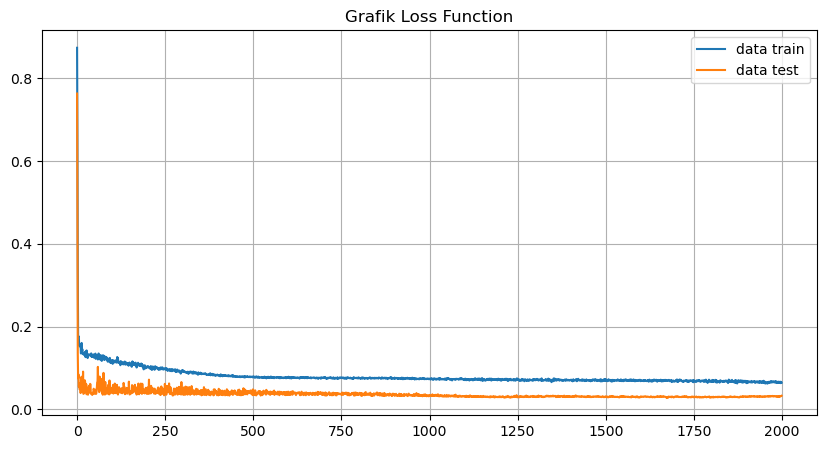

In [46]:
# membuat frame
fig, ax = plt.subplots(figsize = (10,5))

# membuat time series plot
ax.plot(history.history['loss'], color="tab:blue", label="data train", linewidth=1.5)
ax.plot(history.history['val_loss'], color="tab:orange", label="data test", linewidth=1.5)

# membuat label-label
ax.set_title("Grafik Loss Function")
ax.legend(loc='upper right')
ax.grid(True)

# menampilkan plot
plt.show()

In [47]:
# 5. make predictions
predictions = model.predict(testX, verbose=0)
print(predictions[:, 0])

[-0.9955295  -1.0569558  -1.006464   -0.99984205 -0.9983425  -1.0050862
 -0.993017   -0.8813092  -0.35466206 -0.47784716 -0.68270826 -0.99999386
 -0.9965638  -0.98837787 -0.98930025 -0.99162406 -0.9948205  -1.0124965
 -0.99473494 -0.99523455 -0.99558324 -1.0068922  -1.0053859  -0.99638677
 -0.99642164 -0.9965117  -1.001074   -0.99936175 -0.9942412  -0.99107563
 -0.9960861  -0.9908414  -0.99121004 -0.99823296 -0.9976879  -0.99693924
 -1.0043939  -0.99611145 -0.9963344  -0.9964488  -0.99691373 -0.99625844
 -0.9948683  -0.9977109  -0.9963582  -0.9963462  -1.0099648  -0.99648064
 -0.9964641  -0.99649125 -0.99905866 -0.99166834 -1.0314054  -1.0001353
 -1.0001929  -0.9673028  -0.5857391  -0.97732615 -0.997048  ]


### 7. Evaluasi Model LSTM-RNN

In [48]:
scores = model.evaluate(trainX, trainY)
scores

7/7 [==============================] - 0s 2ms/step - loss: 0.0659 - mean_absolute_error: 0.0659 - mean_squared_error: 0.0314 - mean_absolute_percentage_error: 14.2787


[0.06594566255807877,
 0.06594566255807877,
 0.031407784670591354,
 14.278722763061523]

In [49]:
scores = model.evaluate(testX, testY)
scores

2/2 [==============================] - 0s 5ms/step - loss: 0.0329 - mean_absolute_error: 0.0329 - mean_squared_error: 0.0085 - mean_absolute_percentage_error: 5.0320


[0.032872993499040604,
 0.032872993499040604,
 0.0084827970713377,
 5.031961917877197]

- MAE

In [50]:
mae = mean_absolute_error(testY, predictions)
print('Test MAE: %.4f' % mae)

Test MAE: 0.0329


- MSE

In [51]:
mse = mean_squared_error(testY, predictions)
print('Test MSE: %.4f' % mse)

Test MSE: 0.0085


- MAPE

In [52]:
mape = mean_absolute_percentage_error(testY, predictions) * 100
print('Test MAPE: %.4f' % mape)

Test MAPE: 5.0320


- korelasi dan signifikansi

In [53]:
hasil = np.stack((testY,predictions.reshape(-1)),axis=1)
hasil = pd.DataFrame(hasil, columns = ['data_aktual','prediksi'])
hasil.head()

,data_aktual,prediksi
0,-0.999307,-0.995529
1,-0.997922,-1.056956
2,-0.997506,-1.006464
3,-0.990024,-0.999842
4,-0.994319,-0.998343


In [54]:
import scipy.stats as sc
r, p = sc.pearsonr(hasil["data_aktual"], hasil["prediksi"])
print("korelasi data akual dengan hasil prediksi" +" {:.4f} ".format(r)+ "dengan signifikansi" +" {:.4f} ".format(p))

korelasi data akual dengan hasil prediksi 0.7253 dengan signifikansi 0.0000 


- Waktu komputasi

In [55]:
# Set akhir waktu komputasi 
end = tm.time()

In [56]:
# Proses menghitung waktu komputasi
hours, rem = divmod(end-start, 3600)
minutes, seconds = divmod(rem, 60)

In [57]:
# Hasil waktu komputasi
print("{:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),seconds))

00:02:46.40


### 8. Visualisasi Hasil Prediksi

In [58]:
if algorithm == "LSTM-RNN":
    title = "Model Stacked-Bidirectional LSTM-RNN"
else:
    title = "Model Stacked-Bidirectional GRU-RNN"

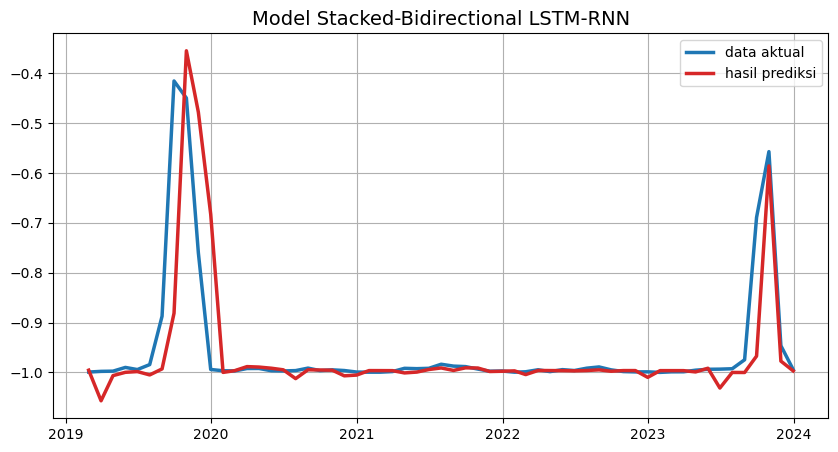

In [59]:
# membuat frame
fig, ax = plt.subplots(figsize = (10,5))

# membuat time series plot
ax.plot(dataset.iloc[len(train_data)+1:len(dataset),0], testY, color="tab:blue", label="data aktual", linewidth=2.5)
ax.plot(dataset.iloc[len(train_data)+1:len(dataset),0], predictions, color="tab:red", label="hasil prediksi", linewidth=2.5)

# membuat label-label
ax.set_title(title, fontsize=14)
ax.set_xlabel("", fontsize=12)
ax.set_ylabel("", fontsize=12)
ax.legend(loc="upper right")
ax.grid(True)
plt.show()